------------------------------------------------------

*Enrique Mateos Melero - 100429073@alumnos.uc3m.es*

*Pablo Santa Cruz Sánchez - 100428988@alumnos.uc3m.es*

*Laura Martínez Díaz - 100428953@alumnos.uc3m.es*

------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from keras.layers import LSTM, Dense
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
!pip install yfinance
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=d12c588b80262da380bf94d7b4ccff3700b2a12bbab6899c2cc5deaf73651ee3
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import yfinance as yf # datos de mercado
import ta # indicadores tecnicos

# Proyecto de *algorithmic trading*

## Inteligencia Artificial en Finanzas

### Máster Universitario en Inteligencia Artificial Aplicada



<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Introducción

Esta práctica consiste en evaluar estrategias de trading mediante *backtesting*.  

# Definir el instrumento

En primer lugar vamos a definir el   instrumento financiero sobre el que vamos a evaluar la estrategia. Vamos a comenzar con The Coca-Cola Company, cuyo ticker es KO.

In [ ]:
my_ticker = 'KO'

# Definir rango temporal para backtestear

El periodo que vamos a usar para comprobar las ventajas de la estrategia son los últimos 6 años completos, es decir, desde el 1 de enero de 2018 al 31 de diciembre de 2023

In [ ]:
Inicio_test='2018-1-1'
Fin_test = '2023-12-31'

La siguiente celda carga los datos desde Yahoo Finance y los guarda en un dataframe con las columnas `Open`, `High`, `Low`, `Close`,  `Adj Close` y `Volume`.

In [ ]:
test_data = yf.download(my_ticker,
                        Inicio_test,
                        Fin_test)

[*********************100%%**********************]  1 of 1 completed


Data Frame de KO


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,45.910000,45.939999,45.509998,45.540001,37.357071,10872200
2018-01-03,45.490002,45.689999,45.340000,45.439999,37.275040,12635600
2018-01-04,45.560001,46.220001,45.450001,46.080002,37.800041,12709400
2018-01-05,46.020000,46.200001,45.790001,46.070000,37.791832,13113100
2018-01-08,45.950001,46.099998,45.880001,46.000000,37.734413,7068600


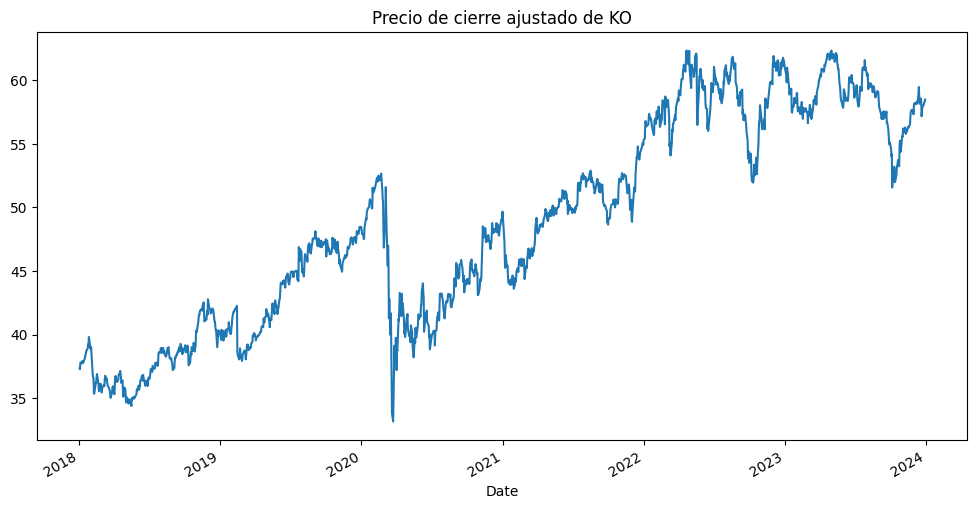

In [ ]:
plt.figure(figsize=(12,6))
test_data['Adj Close'].plot()
_=plt.title('Precio de cierre ajustado de {0}'.format(my_ticker))
print("Data Frame de {0}". format(my_ticker))
test_data.head()

# Definir rangos de parámetros de la estrategia

La estrategia es de doble media deslizante y consiste en detectar:
- si la media móvil a corto plazo es mayor que la media móvil a largo plazo se genera una señal de posición larga, ya que indica tendencia alcista. Cuando hay señal de compra, se compran en mercado un número `S` de unidades (contratos o acciones) del instrumento
- si la media móvil a corto plazo es menor que la media móvil a largo plazo se genera una señal de deshacer posición larga, ya que indica tendencia bajista

Los parámetros de la estrategia son las duraciones de cada ventana, el líquido (*cash*) con el que se comienza y la cantidad de unidades del instrumento `S`  con las que se abre o cierra la posición cuando llega la señal correspondiente.

- **Elegid un valor para la ventana corta y almacenadlo en una variable llamada `short_window`.**
- **Elegid un valor para la ventana larga y almacenadlo en una variable llamada `long_window`.**
- **Ajustad un valor para `S` y el líquido inicial para que la estrategia no incurra en *cash* negativo.**

In [ ]:
# Elegir valores para los parámetros de la estrategia
short_window = 10
print("Longitud ventana rapida {0:d}".format(short_window))
long_window = 50
print("Longitud ventana lenta {0:d}".format(long_window))
S = 100
print("Tamaño ordenes {0:d}".format(S))
cash = 10000
print("Liquidez Inicial {0:.2f} USD".format(cash))

Longitud ventana rapida 10
Longitud ventana lenta 50
Tamaño ordenes 100
Liquidez Inicial 10000.00 USD


# Codificar la estrategia

La clase `BackTester` implementa el código necesario para evaluar la estrategia en modo "for-loop". Entended el código de las celdas siguientes siguiendo las instrucciones que hay en los comentarios

In [ ]:
"""
La clase BackTester implementa el código de evaluar la PnL de la estrategia.
El método position_management se ejecuta dentro de un bucle externo que recibe
los precios de cierre de cada día y genera la orden que se ejecuta el día siguiente,
al precio que se dé ese día.
Una vez ejecutada la orden se almacena la nueva posición (cash + contratos mark-to-market)
"""
class BackTester:
    def __init__(self, cash=10000, S=10, verbose=True):
        self.list_position=[] # almacena las sucesivas posiciones de la estrategia durante el periodo de backtest para poder analizar la evolución temporal
        self.list_cash=[] # almacena las sucesivas posiciones cash de la estrategia durante el periodo de backtest para poder analizar la evolución temporal
        self.list_holdings = [] # almacena el valor mark-to-market de la posición durante el periodo de backtest para poder analizar la evolución temporal
        self.list_total=[] # holdings + cash

        self.position=0 # la estrategia se crea neutra, con una posición a cero acciones
        self.cash=cash # la estrategia se inicia con 10K USD cash
        self.S = S
        self.total=cash # holdings + cash
        self.holdings=0 # la estrategia se crea neutra, con una posición a cero USD
        self.verbose = verbose
    def position_management(self, price_update, long_signal):
        # price_update: diccionario que tiene dos campos
        #               price_update['date']: fecha en formato YYYY-m-d
        #               price_update['price']: adj close del día correspondiente a date
        # long_signal: señal de actuación. Si long_signal==True abrir posición larga con S unidades o mantener.
        #              Si long_signal == False cerrar posición
        if long_signal and self.position<=0: # Detección de señal de posición larga (tendencia ascendente)

            if self.cash >= self.S * price_update['price']: # comprobar tenemos liquidez suficiente
              if self.verbose:
               print(str(price_update['date']) +
                   " send buy order for {0:d} shares price=".format(self.S) + str(price_update['price']))
              self.position += self.S # comprar S unidades
              self.cash -= self.S * price_update['price'] # pagar las S unidades
            else:
              if self.verbose:
                print(str(price_update['date']) +
                   " canceled buy order for {0:d} shares price=".format(self.S) + str(price_update['price']) + " as cash is not enough")
        elif self.position>0 and not long_signal: # Detección de ausencia de señal de posición larga (tendencia descendente)
            if self.verbose:
              print(str(price_update['date'])+
                   " send sell order for {0:d}  shares price=".format(self.S) + str(price_update['price']))
            self.position -= self.S # vender S unidades
            self.cash -= -self.S * price_update['price'] # recibir el importe de la venta

        self.holdings = self.position * price_update['price'] # actualizar mark-to-market de la posicion
        self.total = (self.holdings + self.cash) # actualizar valor total cash + posicion
        if self.verbose:
          print('%s total=%d, holding=%d, cash=%d' %
               (str(price_update['date']),self.total, self.holdings, self.cash))

        # almacenar valores para series históricas
        self.list_position.append(self.position)
        self.list_cash.append(self.cash)
        self.list_holdings.append(self.holdings)
        self.list_total.append(self.total)

In [ ]:
# Generación de los indicadores
# FastSMA: SMA con ventana corta
# SlowSMA: SMA con ventana larga

FastSMA = ta.trend.SMAIndicator(close =test_data['Adj Close'], window=short_window).sma_indicator().dropna()
SlowSMA = ta.trend.SMAIndicator(close = test_data['Adj Close'], window=long_window).sma_indicator().dropna()
# alinear ejes temporales de los dos indicadores
FastSMA = FastSMA.loc[SlowSMA.index]

Text(0.5, 1.0, 'medias móviles')

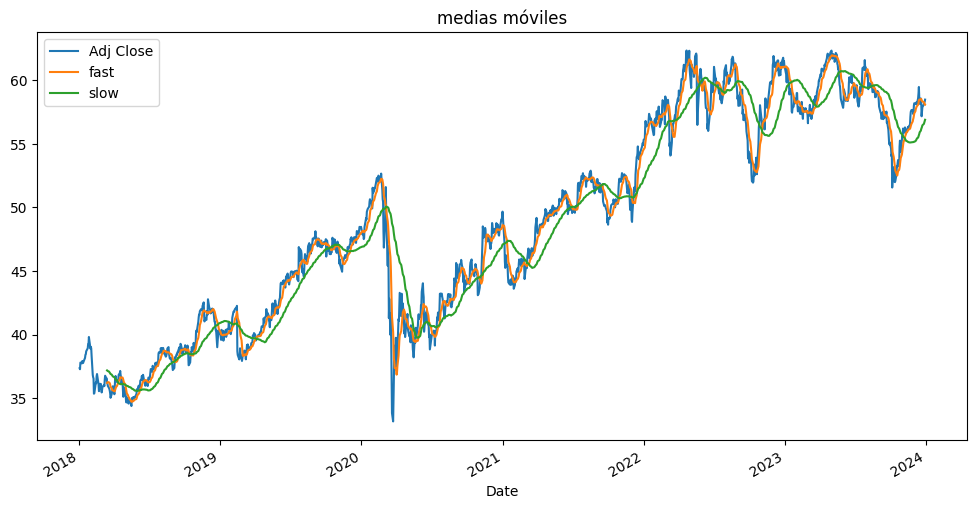

In [ ]:
plt.figure(figsize=(12,6))
test_data['Adj Close'].plot()
plt.title('cierre ajustado')
#plt.figure(figsize=(12,6))
FastSMA.plot(label='fast')
SlowSMA.plot(label='slow')
plt.legend()
plt.title('medias móviles')


**Lógica de la estrategia**: Generamos una señal de posición larga cuando detectemos una tendencia ascendente, es decir, cuando el valor del indicador FastSMA esté por encima del valor de SlowSMA

In [ ]:
LongSignal = FastSMA > SlowSMA

**Backtesting propiamente dicho**

In [ ]:
naive_backtester=BackTester(S=S, cash=cash)
for line in zip(LongSignal.index, test_data.loc[LongSignal.index, 'Adj Close'].values, LongSignal.values):
    date=line[0]
    price=line[1]
    signal = line[2]
    price_information={'date' : date,
                       'price' : float(price)}

    naive_backtester.position_management(price_information, signal)


2018-03-14 00:00:00 total=10000, holding=0, cash=10000
2018-03-15 00:00:00 total=10000, holding=0, cash=10000
2018-03-16 00:00:00 total=10000, holding=0, cash=10000
2018-03-19 00:00:00 total=10000, holding=0, cash=10000
2018-03-20 00:00:00 total=10000, holding=0, cash=10000
2018-03-21 00:00:00 total=10000, holding=0, cash=10000
2018-03-22 00:00:00 total=10000, holding=0, cash=10000
2018-03-23 00:00:00 total=10000, holding=0, cash=10000
2018-03-26 00:00:00 total=10000, holding=0, cash=10000
2018-03-27 00:00:00 total=10000, holding=0, cash=10000
2018-03-28 00:00:00 total=10000, holding=0, cash=10000
2018-03-29 00:00:00 total=10000, holding=0, cash=10000
2018-04-02 00:00:00 total=10000, holding=0, cash=10000
2018-04-03 00:00:00 total=10000, holding=0, cash=10000
2018-04-04 00:00:00 total=10000, holding=0, cash=10000
2018-04-05 00:00:00 total=10000, holding=0, cash=10000
2018-04-06 00:00:00 total=10000, holding=0, cash=10000
2018-04-09 00:00:00 total=10000, holding=0, cash=10000
2018-04-10

La siguente celda representa la evolución temporal de la estrategia, en naranja el *cash* y en azul el valor *mark-to-market* de la posición

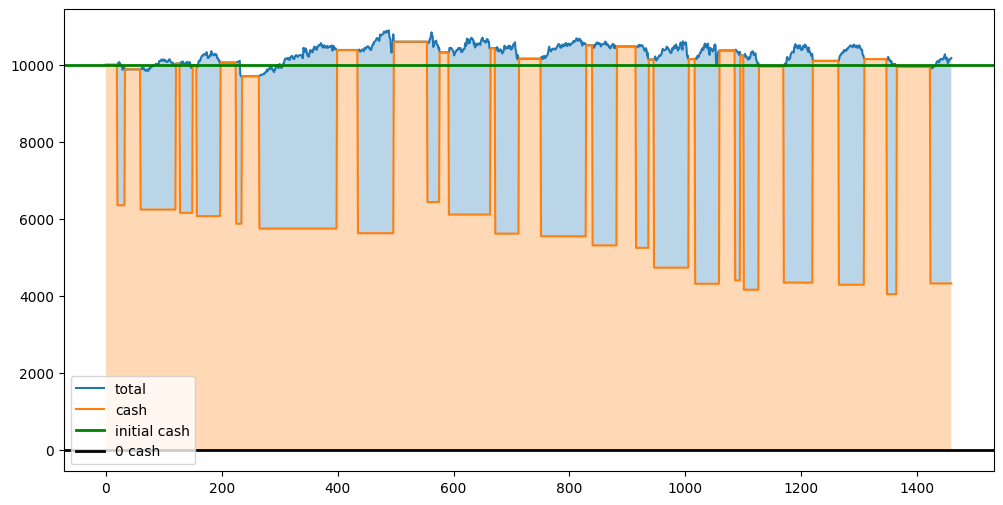

In [ ]:
ff,aa = plt.subplots(1,1,figsize=(12,6))
aa.plot(np.array(naive_backtester.list_total), label='total')
aa.plot(naive_backtester.list_cash, label='cash')
aa.fill_between(np.array(range(len(naive_backtester.list_cash))),np.array(naive_backtester.list_cash), np.array(naive_backtester.list_total), alpha=0.3)
aa.fill_between(np.array(range(len(naive_backtester.list_cash))), np.array(range(len(naive_backtester.list_cash)))*0.,np.array(naive_backtester.list_cash), alpha=0.3)
aa.axhline(10000,color='green', lw=2, label='initial cash')
aa.axhline(0,color='black',lw=2,label='0 cash')
_=aa.legend()

In [ ]:
print("PnL real {0:.2f}%".format((naive_backtester.total - cash)/cash*100))

PnL real 1.74%


# Apartados a desarrollar

## 1.- Backtesting con conjunto de entrenamiento y conjunto de test separados

Hay dos parámetros clave para la estrategia que son las longitudes de las ventanas. La manera correcta es utilizar un conjunto de entrenamiento para  elegir los parámetros óptimos y ver la PnL que se obtiene usando estos parámetros óptimos en test.

El conjunto de test lo hemos definido antes, son los 6 años de 1 enero 2018 a 31 diciembre de 2023.

### 1.1.- Selección del conjunto de entrenamiento

Para conjunto de entrenamiento vamos a usar inicialmente los datos de 1 enero 2001 a 31 diciembre 2017

La manera de decidir cuáles son los mejores parámetros para la estrategia consiste en evaluar su *PnL* con todas las combinaciones posibles de valores de parámetro en un rango de fechas denominado **conjunto de entrenamiento** y elegir la combinación de parámetros que proporcione la *PnL* más alta.

Esta combinación ganadora de parámetros se evalúa en las fechas del denominado **conjunto de test**. La *PnL* que la estrategia alcanza en el conjunto de test es nuestra estimación de la *PnL* que obtendremos en producción.

**Obtener el conjunto de entrenamiento correspondiente desde Yahoo Finance**

In [ ]:
def load_data(ticker: str, fecha_inicio: str, fecha_fin: str):
    return yf.download(ticker, fecha_inicio, fecha_fin)


def backtesting_training(train_data: pd.DataFrame, function: str="SMA"):
    best_pnl = float('-inf')
    best_config = None

    for i, short_window in enumerate([10, 20, 40, 80]):
        for j, long_window in enumerate([50, 100, 150, 200]):
            if function == "SMA":
                FastSMA = ta.trend.SMAIndicator(close =train_data['Adj Close'], window=short_window).sma_indicator().dropna()
                SlowSMA = ta.trend.SMAIndicator(close = train_data['Adj Close'], window=long_window).sma_indicator().dropna()
                # alinear ejes temporales de los dos indicadores
                if short_window < long_window:
                    FastSMA = FastSMA.loc[SlowSMA.index]
                else:
                    SlowSMA = SlowSMA.loc[FastSMA.index]
                LongSignal = FastSMA > SlowSMA
            elif function == "EMA":
                FastEMA = ta.trend.EMAIndicator(close =train_data['Adj Close'], window=short_window).ema_indicator().dropna()
                SlowEMA = ta.trend.EMAIndicator(close = train_data['Adj Close'], window=long_window).ema_indicator().dropna()
                # alinear ejes temporales de los dos indicadores
                if short_window < long_window:
                    FastEMA = FastEMA.loc[SlowEMA.index]
                else:
                    SlowEMA = SlowEMA.loc[FastEMA.index]
                LongSignal = FastEMA > SlowEMA
            elif function == "RSI":
                if j != 0:
                    continue
                short_window = short_window - (3 * (2**i))
                RSI = ta.momentum.RSIIndicator(close =train_data['Adj Close'], window=short_window).rsi().dropna()
                LongSignal = RSI < 70
            else:
                raise NotImplementedError

            naive_backtester=BackTester(S=S, cash=cash, verbose=False)
            for line in zip(LongSignal.index, train_data.loc[LongSignal.index, 'Adj Close'].values, LongSignal.values):
                date=line[0]
                price=line[1]
                signal = line[2]
                price_information={'date' : date,
                                'price' : float(price)}

                naive_backtester.position_management(price_information, signal)

            current_pnl = (naive_backtester.total - cash)/cash*100
            if current_pnl > best_pnl:
                best_pnl = current_pnl
                best_config = (short_window, long_window)
                print('\n')
                print("Best PnL: ", best_pnl)
                if function == "RSI":
                    print("Best configuration: " + "Window - " +  str(best_config[0]))
                else:
                    print("Best configuration: " + "Short window - " +  str(best_config[0]) + ", Long Window - " + str(best_config[1]))

    return best_pnl, best_config


def backtesting_test(test_data: pd.DataFrame, short_window: int, long_window: int, function: str="SMA"):
    if function == "SMA":
        FastSMA = ta.trend.SMAIndicator(close =test_data['Adj Close'], window=short_window).sma_indicator().dropna()
        SlowSMA = ta.trend.SMAIndicator(close = test_data['Adj Close'], window=long_window).sma_indicator().dropna()
        # alinear ejes temporales de los dos indicadores
        if short_window < long_window:
            FastSMA = FastSMA.loc[SlowSMA.index]
        else:
            SlowSMA = SlowSMA.loc[FastSMA.index]
        LongSignal = FastSMA > SlowSMA
    elif function == "EMA":
        FastEMA = ta.trend.EMAIndicator(close =test_data['Adj Close'], window=short_window).ema_indicator().dropna()
        SlowEMA = ta.trend.EMAIndicator(close = test_data['Adj Close'], window=long_window).ema_indicator().dropna()
        # alinear ejes temporales de los dos indicadores
        if short_window < long_window:
            FastEMA = FastEMA.loc[SlowEMA.index]
        else:
            SlowEMA = SlowEMA.loc[FastEMA.index]
        LongSignal = FastEMA > SlowEMA
    elif function == "RSI":
        RSI = ta.momentum.RSIIndicator(close =test_data['Adj Close'], window=short_window).rsi().dropna()
        LongSignal = RSI < 70
    else:
        raise NotImplementedError
    naive_backtester=BackTester(S=S, cash=cash, verbose=False)
    for line in zip(LongSignal.index, test_data.loc[LongSignal.index, 'Adj Close'].values, LongSignal.values):
        date=line[0]
        price=line[1]
        signal = line[2]
        price_information={'date' : date,
                        'price' : float(price)}

        naive_backtester.position_management(price_information, signal)

    current_pnl = (naive_backtester.total - cash)/cash*100
    print("Best PnL: ", current_pnl)
    if function == "RSI":
        print("Best configuration: " + "Window - " +  str(short_window))
    else:
        print("Best configuration: " + "Short window - " +  str(short_window) + ", Long Window - " + str(long_window))

In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
train_data = load_data("KO", '2001-1-1', '2017-12-31')

[*********************100%%**********************]  1 of 1 completed


Data Frame de KO


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,30.46875,30.96875,30.12500,30.40625,15.773697,10606000
2001-01-03,30.40625,31.09375,29.53125,29.62500,15.368411,12469600
2001-01-04,29.43750,29.43750,28.37500,28.78125,14.930700,14770600
2001-01-05,28.78125,29.37500,28.75000,28.84375,14.963131,7960200
2001-01-08,28.90625,29.84375,28.90625,29.31250,15.206301,9529200


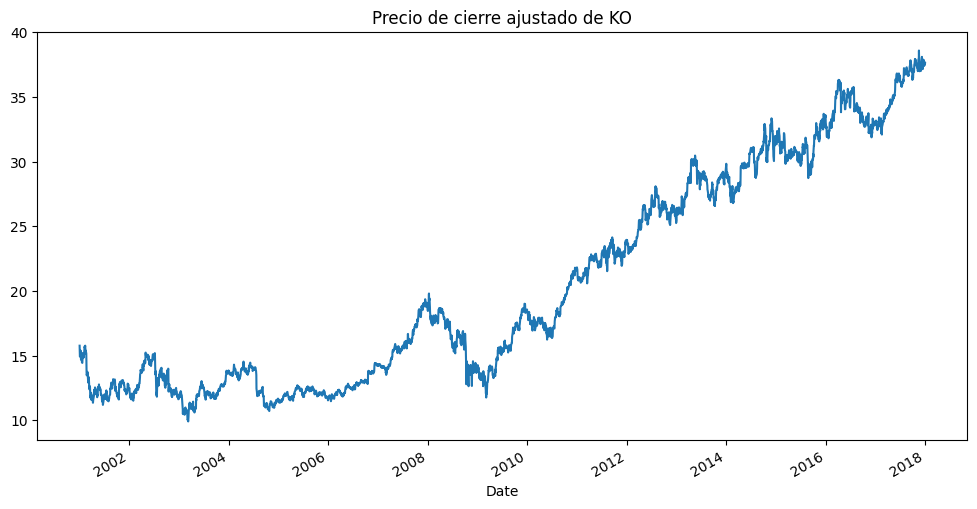

In [ ]:
plt.figure(figsize=(12,6))
train_data['Adj Close'].plot()
_=plt.title('Precio de cierre ajustado de {0}'.format(my_ticker))
print("Data Frame de {0}". format(my_ticker))
train_data.head()

### 1.2.- Rangos de parámetros

Los rangos de parámetros que vamos a explorar son:
- Ventana rápida: 10, 20, 40, 80 días
- Ventana lenta: 50, 100, 150, 200 días

### 1.3.- Grid Search

**Programad un código (bucles anidados) que obtenga la PnL en el periodo de entrenamiento de cada una las combinaciones de `(short_window, long_window)` que se puedan definir con los rangos del apartado anterior**



In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
best_pnl, best_config = backtesting_training(train_data)



Best PnL:  3.069087028503418
Best configuration: Short window - 10, Long Window - 50


Best PnL:  10.740473747253418
Best configuration: Short window - 10, Long Window - 100


Best PnL:  14.383651733398436
Best configuration: Short window - 10, Long Window - 150


Best PnL:  15.627624511718748
Best configuration: Short window - 20, Long Window - 100


Best PnL:  15.911477088928223
Best configuration: Short window - 20, Long Window - 150


Best PnL:  18.599567413330078
Best configuration: Short window - 40, Long Window - 50


Best PnL:  19.257149696350098
Best configuration: Short window - 40, Long Window - 100


Best PnL:  20.105772972106934
Best configuration: Short window - 80, Long Window - 150


### 1.4.- Evaluacion en Test

**Comprobar la PnL real que se obtiene con los mejores parámetros ajustados en entrenamiento**

Para aislar los resultados del *cash* inicial podeis calcular una PnL porcentual usando la fórmula
$$
\mbox{PnL} (\%) = \frac{\mbox{PnL_final} -\mbox{cash_inicial}}{\mbox{cash_inicial}}\times 100
$$


In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
backtesting_test(test_data, best_config[0], best_config[1])

Best PnL:  7.618183135986328
Best configuration: Short window - 80, Long Window - 150


**Probad diferentes intervalos de entrenamiento (por ejemplo últimos 10 años o 5 años, o 2 años, etc) para ver su impacto en los parámetros que se eligen, y en consecuencia en la PnL que se obtiene en test.**

In [ ]:
# 10 años
train_data_10 = load_data("KO", '2008-1-1', '2017-12-31')

[*********************100%%**********************]  1 of 1 completed


Data Frame de KO


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,30.46875,30.96875,30.12500,30.40625,15.773697,10606000
2001-01-03,30.40625,31.09375,29.53125,29.62500,15.368411,12469600
2001-01-04,29.43750,29.43750,28.37500,28.78125,14.930700,14770600
2001-01-05,28.78125,29.37500,28.75000,28.84375,14.963131,7960200
2001-01-08,28.90625,29.84375,28.90625,29.31250,15.206301,9529200


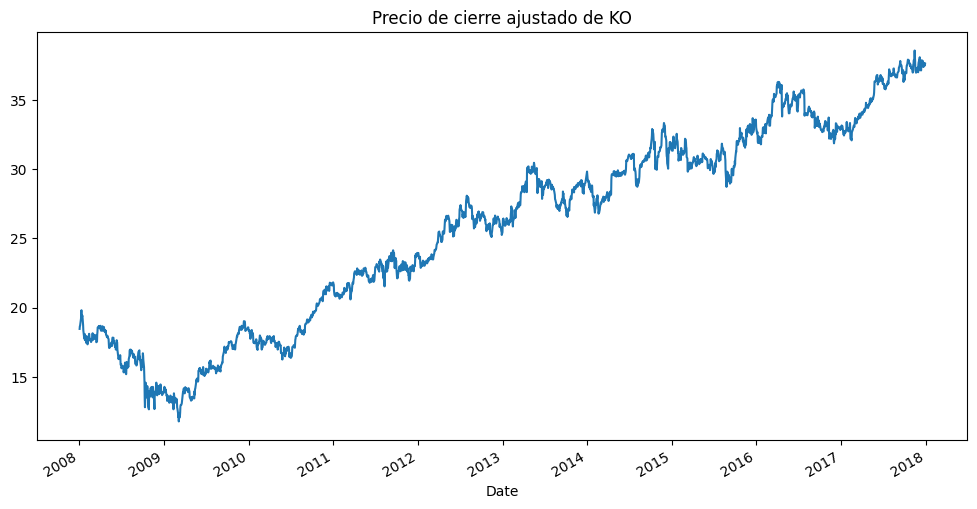

In [ ]:
plt.figure(figsize=(12,6))
train_data_10['Adj Close'].plot()
_=plt.title('Precio de cierre ajustado de {0}'.format(my_ticker))
print("Data Frame de {0}". format(my_ticker))
train_data.head()

In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
print("Using last 10 years")
best_pnl, best_config = backtesting_training(train_data_10)

Using last 10 years


Best PnL:  3.0825624465942383
Best configuration: Short window - 10, Long Window - 50


Best PnL:  9.339353561401367
Best configuration: Short window - 10, Long Window - 100


Best PnL:  12.468155860900879
Best configuration: Short window - 10, Long Window - 150


Best PnL:  13.540640830993652
Best configuration: Short window - 20, Long Window - 100


Best PnL:  16.195531845092773
Best configuration: Short window - 40, Long Window - 100


In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
backtesting_test(test_data, best_config[0], best_config[1])

Best PnL:  -7.31570816040039
Best configuration: Short window - 40, Long Window - 100


In [ ]:
# 5 años
train_data_5 = load_data("KO", '2013-1-1', '2017-12-31')

[*********************100%%**********************]  1 of 1 completed


Data Frame de KO


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,30.46875,30.96875,30.12500,30.40625,15.773697,10606000
2001-01-03,30.40625,31.09375,29.53125,29.62500,15.368411,12469600
2001-01-04,29.43750,29.43750,28.37500,28.78125,14.930700,14770600
2001-01-05,28.78125,29.37500,28.75000,28.84375,14.963131,7960200
2001-01-08,28.90625,29.84375,28.90625,29.31250,15.206301,9529200


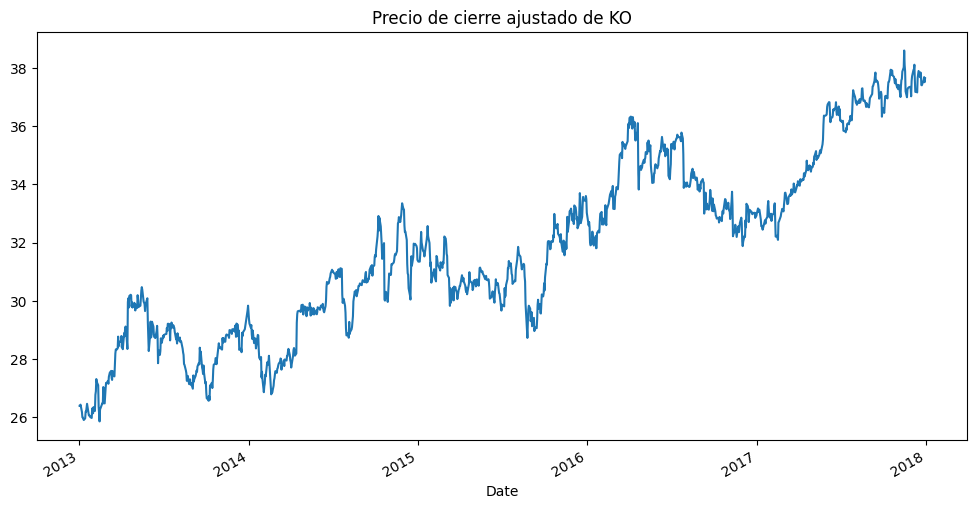

In [ ]:
plt.figure(figsize=(12,6))
train_data_5['Adj Close'].plot()
_=plt.title('Precio de cierre ajustado de {0}'.format(my_ticker))
print("Data Frame de {0}". format(my_ticker))
train_data.head()

In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
print("Using last 5 years")
best_pnl, best_config = backtesting_training(train_data_5)

Using last 5 years


Best PnL:  -1.8325004577636719
Best configuration: Short window - 10, Long Window - 50


Best PnL:  -1.2508506774902344
Best configuration: Short window - 10, Long Window - 100


Best PnL:  1.5207061767578125
Best configuration: Short window - 10, Long Window - 150


Best PnL:  3.1485671997070317
Best configuration: Short window - 10, Long Window - 200


Best PnL:  6.769382476806641
Best configuration: Short window - 40, Long Window - 50


In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
backtesting_test(test_data, best_config[0], best_config[1])

Best PnL:  -7.899204254150391
Best configuration: Short window - 40, Long Window - 50


In [ ]:
# 2 años
train_data_2 = load_data("KO", '2016-1-1', '2017-12-31')

[*********************100%%**********************]  1 of 1 completed


Data Frame de KO


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,30.46875,30.96875,30.12500,30.40625,15.773697,10606000
2001-01-03,30.40625,31.09375,29.53125,29.62500,15.368411,12469600
2001-01-04,29.43750,29.43750,28.37500,28.78125,14.930700,14770600
2001-01-05,28.78125,29.37500,28.75000,28.84375,14.963131,7960200
2001-01-08,28.90625,29.84375,28.90625,29.31250,15.206301,9529200


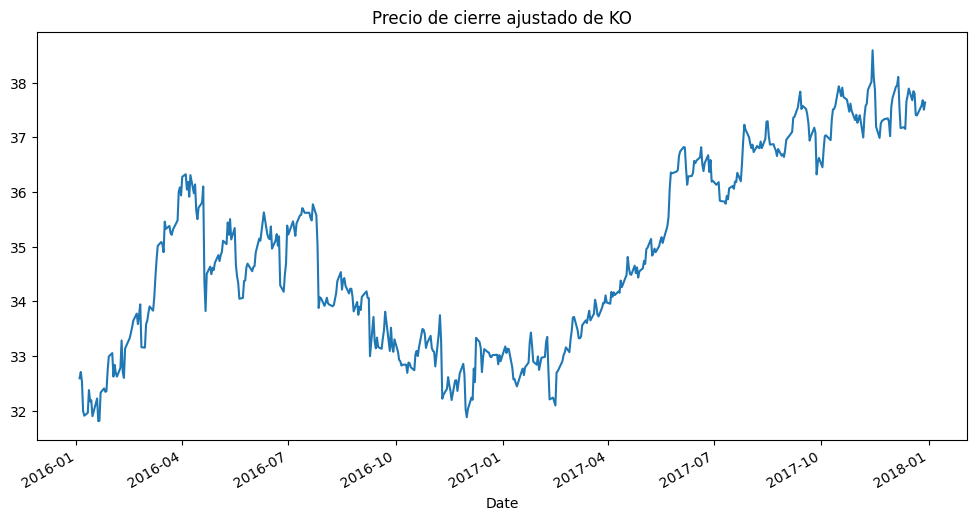

In [ ]:
plt.figure(figsize=(12,6))
train_data_2['Adj Close'].plot()
_=plt.title('Precio de cierre ajustado de {0}'.format(my_ticker))
print("Data Frame de {0}". format(my_ticker))
train_data.head()

In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
print("Using last 2 years")
best_pnl, best_config = backtesting_training(train_data_2)

Using last 2 years


Best PnL:  -1.0074386596679688
Best configuration: Short window - 10, Long Window - 50


Best PnL:  3.0692062377929688
Best configuration: Short window - 10, Long Window - 100


Best PnL:  3.922748565673828
Best configuration: Short window - 10, Long Window - 150


Best PnL:  4.626747131347656
Best configuration: Short window - 20, Long Window - 150


In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
backtesting_test(test_data, best_config[0], best_config[1])

Best PnL:  1.9929161071777346
Best configuration: Short window - 20, Long Window - 150


Tras analizar toda la combinatoria de parámetros para la compañía de Coca-Cola (años para entrenar, ventana corta y ventana larga) se ha podido observar, que el mejor conjunto es usando todos los datos desde el 2001 y con unas ventanas corta y larga de 80 y 15 respectivamente. Además, salvo en el caso de los dos años de entrenamiento, que pueden ser más representativos de la tendencia más temprana de la empresa, en los casos de usar los últimos 5 y 10 años, la estrategia sobre el conjunto de test no conseguía ningún tipo de beneficio.

También se ha podido observar que en general usar ventanas más amplias (tanto en las rápidas como en las lentas) obtiene mejores resultados. Esto se puede deber a que se aseguran más de que el crecimiento sea significativo y constante y no un pico puntual.

Por último, nos parece interesante destacar que esta estrategia se podría modificar para que se sigan comprando acciones si la señal de compra sigue siendo positiva. Esto crearía un mayor riesgo ya que se pondría más dinero en juego, pero también podría generar más beneficio. Habría que en ese caso, poner un límite de compra o algún otro método de aversión al riesgo.

# 2.- Probad un instrumento distinto de The Coca-Cola Company

Aplicad la estrategia (con selección de parámetros) a un instrumento distinto de The Coca-Cola Company. Comentad si los valores de los parámetros y la PnL alcanzada son muy diferentes de los obtenidos con The Coca-Cola Company.

In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
my_ticker = 'NVDA'
max_PnL = float('-inf')
max_Config = {'years': '',
              'short': 0,
              'long': 0
              }
for time_spare in ('2001-1-1', '2008-1-1', '2013-1-1', '2016-1-1'):
    train_data_trainer = load_data("NVDA", time_spare, '2017-12-31')
    print("\n")
    pnl, config = backtesting_training(train_data_trainer)
    if pnl > max_PnL:
        max_PnL = pnl
        max_Config['years'] = time_spare
        max_Config['short'] = config[0]
        max_Config['long'] = config[1]

print("\n")
print("The best PnL value is:", max_PnL)
print(f"The configuration for that PnL is: \n\t- Year: {max_Config['years']} \n\t- Short_window: {max_Config['short']} \n\t- Long_window: {max_Config['long']}")

[*********************100%%**********************]  1 of 1 completed






Best PnL:  45.49876445531845
Best configuration: Short window - 10, Long Window - 50


Best PnL:  46.34759724140167
Best configuration: Short window - 10, Long Window - 150


Best PnL:  48.46164906024933
Best configuration: Short window - 10, Long Window - 200


[*********************100%%**********************]  1 of 1 completed






Best PnL:  38.25788748264313
Best configuration: Short window - 10, Long Window - 50


Best PnL:  43.33771562576294
Best configuration: Short window - 10, Long Window - 150


Best PnL:  43.995156049728394
Best configuration: Short window - 10, Long Window - 200


Best PnL:  45.08953094482422
Best configuration: Short window - 20, Long Window - 150


Best PnL:  45.263506174087524
Best configuration: Short window - 80, Long Window - 100


[*********************100%%**********************]  1 of 1 completed






Best PnL:  38.74058127403259
Best configuration: Short window - 10, Long Window - 50


Best PnL:  42.04792356491089
Best configuration: Short window - 10, Long Window - 150


Best PnL:  42.81287431716919
Best configuration: Short window - 10, Long Window - 200


Best PnL:  42.96761083602905
Best configuration: Short window - 20, Long Window - 150


Best PnL:  43.360907554626465
Best configuration: Short window - 40, Long Window - 150


Best PnL:  43.580986976623535
Best configuration: Short window - 40, Long Window - 200


Best PnL:  44.20404005050659
Best configuration: Short window - 80, Long Window - 200


[*********************100%%**********************]  1 of 1 completed





Best PnL:  37.91992235183716
Best configuration: Short window - 10, Long Window - 50


Best PnL:  40.63668918609619
Best configuration: Short window - 40, Long Window - 50


The best PnL value is: 48.46164906024933
The configuration for that PnL is: 
	- Year: 2001-1-1 
	- Short_window: 10 
	- Long_window: 200


In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
test_data = load_data("NVDA", "2018-1-1", '2023-12-31')
print()
backtesting_test(test_data, max_Config["short"], max_Config["long"])

[*********************100%%**********************]  1 of 1 completed


Best PnL:  435.847427368164
Best configuration: Short window - 10, Long Window - 200


En cuanto al otro instrumento seleccionado, la empresa NVIDIA, se obtiene que la mejor configuración es teniendo en cuenta los datos desde 2001, con una ventana rápida de 10 días y una lenta de 200. Cabe mencionar que este activo ha experimentado un crecimiento muy alto en los últimos años, por lo que el PnL tan alto obtenido en test es en gran parte gracias a esto.

# 3.- Probad una estrategia basada en otros indicadores

Siguiendo la metodología establecida en este cuaderno, **diseñad y evaluad una estrategia de trading** (podéis adaptar la lógica de la estrategia de este cuaderno) para **otro instrumento distinto de The Coca-Cola Company** (aseguraos de que tenga datos históricos suficientes) durante los mismos 6 años que hemos usado como conjunto de test.

La lógica de la estrategia estará basada en alguno de estos indicadores:
- EMA
- RSI

Indicad claramente:
- la lógica de la estrategia
- los parámetros de los que depende la estrategia
- el conjunto de entrenamiento que empleáis para ajustar estos valores, justificando la elección de dicho conjunto.
- los valores para estos parámetros obtenidos en un conjunto de entrenamiento
- la PnL de test

## EMA

En este caso hemos decidido seguir la misma estrategia que con SMA pero con el calculo de la media deslizante exponencial, ponderando los datos recientes con un peso exponencialmente mayor que los datos antiguos. Esta media suele ajustarse más rápido a los cambios de tendencia. Al igual que con SMA se ha usado una ventana larga y una ventana corta y cuando la ventana rápida corta de abajo a arriba a la larga, se da la señal para ponerse en largo, y cuando ocurre lo contrario se devuelve la posición.

Los parámetros a usar para esta estrategia se basan en los tamaños de la ventana y el número de datos para entrenar:
- Ventana corta: 10, 20, 40, 80
- Ventana larga: 50, 100, 150, 200
- Años de entrenamiento: desde 2001 o desde 2008 o desde 2013 o desde 2016 hasta 2017

Se ha probado toda la combinatoria y el resultado para la mejor combinación y su paso al conjunto de test se pueden ver en la salida de la siguiente celda.

In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
# For EMA
my_ticker = 'NVDA'
max_PnL = float('-inf')
max_Config = {'years': '',
              'short': 0,
              'long': 0
              }
for time_spare in ('2001-1-1', '2008-1-1', '2013-1-1', '2016-1-1'):
    train_data_trainer = load_data("NVDA", time_spare, '2017-12-31')
    print("\n")
    pnl, config = backtesting_training(train_data_trainer, "EMA")
    if pnl > max_PnL:
        max_PnL = pnl
        max_Config['years'] = time_spare
        max_Config['short'] = config[0]
        max_Config['long'] = config[1]

print("\n")
print("The best PnL value is:", max_PnL)
print(f"The configuration for that PnL is: \n\t- Year: {max_Config['years']} \n\t- Short_window: {max_Config['short']} \n\t- Long_window: {max_Config['long']}")
print()
backtesting_test(test_data, max_Config["short"], max_Config["long"], "EMA")

[*********************100%%**********************]  1 of 1 completed






Best PnL:  42.73792737722397
Best configuration: Short window - 10, Long Window - 50


Best PnL:  44.90064525604248
Best configuration: Short window - 10, Long Window - 150


Best PnL:  45.979588866233826
Best configuration: Short window - 10, Long Window - 200


Best PnL:  46.510300159454346
Best configuration: Short window - 20, Long Window - 150


[*********************100%%**********************]  1 of 1 completed



Best PnL:  46.97768533229828
Best configuration: Short window - 40, Long Window - 100




Best PnL:  36.38913536071777
Best configuration: Short window - 10, Long Window - 50


Best PnL:  40.78599548339844
Best configuration: Short window - 10, Long Window - 100


Best PnL:  42.38304603099823
Best configuration: Short window - 10, Long Window - 150



[*********************100%%**********************]  1 of 1 completed



Best PnL:  42.68265724182129
Best configuration: Short window - 10, Long Window - 200


Best PnL:  44.18915557861328
Best configuration: Short window - 20, Long Window - 150


Best PnL:  44.6939959526062
Best configuration: Short window - 40, Long Window - 100




Best PnL:  36.9411358833313
Best configuration: Short window - 10, Long Window - 50




Best PnL:  41.84096956253052
Best configuration: Short window - 10, Long Window - 100


Best PnL:  41.84413480758667
Best configuration: Short window - 10, Long Window - 150


Best PnL:  43.02770757675171
Best configuration: Short window - 10, Long Window - 200


Best PnL:  43.12561559677124
Best configuration: Short window - 20, Long Window - 150


Best PnL:  43.22834348678589
Best configuration: Short window - 20, Long Window - 200


[*********************100%%**********************]  1 of 1 completed



Best PnL:  43.52619123458862
Best configuration: Short window - 40, Long Window - 150


Best PnL:  44.45346546173096
Best configuration: Short window - 80, Long Window - 150




Best PnL:  35.482765674591064
Best configuration: Short window - 10, Long Window - 50


Best PnL:  36.77080059051514
Best configuration: Short window - 10, Long Window - 100


Best PnL:  38.74275255203247
Best configuration: Short window - 40, Long Window - 50


The best PnL value is: 46.97768533229828
The configuration for that PnL is: 
	- Year: 2001-1-1 
	- Short_window: 40 
	- Long_window: 100

Best PnL:  404.5822715759277
Best configuration: Short window - 40, Long Window - 100


## RSI

En el caso de la estrategia RSI, se calcula el promedio de las variaciones a la alta y a la baja para el periodo seleccionado y posteriormente se dividen. De esta manera, se obtiene el término RS, fuerza relativa por sus siglas en inglés y se hace uso de la siguiente fórmula:

$RSI = 100 - \frac{100}{(1 + RS)}$

Una vez hecho este cálculo, si la variación al alza es superior a la de la baja, el valor de RSI será más cercano a 100. En el caso contrario, será cercano a 0. Con esta estrategia, nos interesa comprar cuando se considera un mercado bajista y se suelen definir dos límites para realizar las posiciones de compra y venta. Por lo que hemos visto, a se suele realizar posiciones de compra si el valor es 30 o menos y posiciones de venta si el valor es 70 o más. Dado que solo se implementa una estrategia de posiciones en largo, hemos decidido comprar siempre que el valor sea menor que 70.

Los parámetros a usar para esta estrategia se basan en los tamaños de la ventana y el número de datos para entrenar:
- Ventana: 7, 14, 28, 56
- Años de entrenamiento: desde 2001 o desde 2008 o desde 2013 o desde 2016 hasta 2017

Se ha probado toda la combinatoria y el resultado para la mejor combinación y su paso al conjunto de test se pueden ver en la salida de la siguiente celda.

In [ ]:
#####################
# VUESTRA RESPUESTA #
#####################
# For RSI
my_ticker = 'NVDA'
max_PnL = float('-inf')
max_Config = {'years': '',
              'short': 0,
              'long': 0
              }
for time_spare in ('2001-1-1', '2008-1-1', '2013-1-1', '2016-1-1'):
    train_data_trainer = load_data("NVDA", time_spare, '2017-12-31')
    print("\n")
    pnl, config = backtesting_training(train_data_trainer, "RSI")
    if pnl > max_PnL:
        max_PnL = pnl
        max_Config['years'] = time_spare
        max_Config['short'] = config[0]
        max_Config['long'] = config[1]

print("\n")
print("The best PnL value is:", max_PnL)
print(f"The configuration for that PnL is: \n\t- Year: {max_Config['years']} \n\t- Window: {max_Config['short']}")
print()
backtesting_test(test_data, max_Config["short"], max_Config["long"], "RSI")

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed




Best PnL:  33.78058874607086
Best configuration: Window - 7


Best PnL:  37.2373286485672
Best configuration: Window - 14


Best PnL:  46.978111743927
Best configuration: Window - 28




Best PnL:  27.237766623497013
Best configuration: Window - 7


Best PnL:  33.24778461456299
Best configuration: Window - 14


Best PnL:  42.37295913696289
Best configuration: Window - 28


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed






Best PnL:  30.9180269241333
Best configuration: Window - 7


Best PnL:  37.58020877838135
Best configuration: Window - 14


Best PnL:  46.98224139213562
Best configuration: Window - 28




Best PnL:  26.324297428131104
Best configuration: Window - 7


Best PnL:  33.223674297332764
Best configuration: Window - 14


Best PnL:  43.00644826889038
Best configuration: Window - 28


The best PnL value is: 46.98224139213562
The configuration for that PnL is: 
	- Year: 2013-1-1 
	- Window: 28

Best PnL:  409.08023834228516
Best configuration: Window - 28


Se puede observar que SMA es el indicador que mejor PnL obtiene en el conjunto de prueba. En el caso de EMA, al ponderar de manera exponencial, tanto la ventana corta como la larga se ajustan más a la tendencia real, mientras que SMA es menos sensible a cambios bruscos, suavizando las tendencias y sobreajustándose menos a las fluctuaciones del mercado. Parece que emplear un indicador más conservador tiene un impacto positivo en el beneficio obtenido.

Por otra parte, el indicador RSI está pensado para seguir una estrategia de ponerse en corto cuando está por encima de un umbral, y ponerse en largo cuando está por debajo, manteniéndote cuando el RSI se encuentra entre ambos valores. La estrategia planteada por nosotros consiste en simplemente ponerse en corto cuando se supera el umbral, por lo que su rendimiento no es tan bueno.

En general, cabe también mencionar que la empresa escogida, NVIDIA, ha estado en continuo crecimiento desde 2018, cuando empieza el periodo de test, por lo que los PnL en general son bastante altos.

# 4.- Estrategia basada en Aprendizaje Automático.

Vamos a probar una estrategia sencilla que usa un predictor basado en aprendizaje automático para decidir si invertir o no. El core de la estrategia es un predictor que nos dice si cada día el precio *close* va a acabar por encima del precio *open*. Para construir este predictor podemos usar por ejemplo un regresor logístico que tome como entradas los precios *open*, *close*, *high* y *low* del día anterior. Este predictor se entrenaría con los datos del conjunto de entrenamiento. Para facilitar combinar datos de rangos temporales amplios, puede ser intersante en lugar de alimentar el predictor con los precios *open*, *close*, *high* y *low*, usar diferencias [porcentuales] tales como:
* (close - open)
* (close - open)/open
* (high - low)/low
* (high - open)/open
* (open -low)/open
* ...


Los targets serían $+1$ si el día en cuestión el precio *close* acabará por encima del *open* o $-1$ en caso contrario.

Alternativamente se pueden usar otros modelos de aprendizaje automático, como por ejemplo un regresor que prediga la diferencia close-open y abrir operar si esta diferencia es positiva (o mayor que un umbral que dependa de nuestra aversión al riesgo).

La lógica de la estrategia sería la siguiente:
- Si el predictor dice que el *close* va a estar por encima del *open*, compramos al *open* y vendemos al *close* **en el mismo día**. Por tanto, si el predictor acierta, ganamos el retorno intradía (y si falla lo perdemos)
- Si el predictor dice que el *close* no va a estar por encima del *open*, no hacemos nada.

Comparar la ganancia de esta estrategia en los dos instrumentos donde hemos evaluado la anterior durante el mismo periodo de test y discutir cuál es la mejor opción.

## Estrategia

Dado que se pretende seguir una estrategia intradia, los datos a introducir serían el precio para ese día en el open y el close. Como señal, usaremos la predicción de un regresor basado en redes recurrentes (en concreto una LSTM), que intentará predecir la diferencia entre el precio de cierre y el de apertura. Los datos de entrenamiento de la LSTM serán todos los datos desde el 2001 hasta finales de 2017. Cabe destacar que se destinarán el 20% de los últimos datos como conjunto de validación.

De esta manera, cuando la predicción supere el 0, es decir se espera que cierre con más valor que con el que abre, se comprarán las N acciones al precio del open y se venderán justo después al precio del close (simulando en un solo paso el transcurso del día entero). En el caso de que la señal sea más baja de 0 no se hace ningún tipo de movimiento.

A modo de comparar de manera fehaciente con los resultados anteriores, se empieza con el mismo cash inicial. Las operaciones de compra si que se ven afectadas ya que hemos decidido que el volumen de compra sea proporcional a la magnitud de la señal en base a la siguiente fórmula:

$S = ⌊ signal * 100 ⌋$

In [ ]:
class BackTesterRegression:
    def __init__(self, cash=10000, S=10, verbose=True):
        self.list_cash=[] # almacena las sucesivas posiciones cash de la estrategia durante el periodo de backtest para poder analizar la evolución temporal
        self.list_total=[] # holdings + cash

        self.cash=cash # la estrategia se inicia con 10K USD cash
        self.S = S
        self.total=cash # holdings + cash
        self.verbose = verbose
    def position_management(self, price_update, long_signal):
        # price_update: diccionario que tiene tres campos
        #               price_update['date']: fecha en formato YYYY-m-d
        #               price_update['open']: valor de apertura
        #               price_update['close']: valor de cierre
        # long_signal: señal de actuación. Si long_signal > 0 abrir posición larga con S unidades para ese día.
        #              Se compra al valor de apertura, y se vende al de cierre.
        if long_signal > 0: # Detección de señal de posición larga (close será mayor que open)
            self.S = int(long_signal * 100)
            if self.cash >= self.S * price_update['open']: # comprobar tenemos liquidez suficiente
              if self.verbose:
               print(str(price_update['date']) +
                   " send buy order for {0:d} shares price=".format(self.S) + str(price_update['open']))
              self.cash -= self.S * price_update['open'] # comprar las S unidades a precio de apertura
              self.cash += self.S * price_update['close'] # vender las S unidades a precio de cierre
            else:
              if self.verbose:
                print(str(price_update['date']) +
                   " canceled buy order for {0:d} shares price=".format(self.S) + str(price_update['open']) + " as cash is not enough")

        # Si la señal de nuestro predictor es menor que 0, no haremos nada

        self.total = self.cash # Al final del día, siempre tendremos solo cash, ya que no mantenemos acciones entre días
        if self.verbose:
          print('%s total=%d, cash=%d' %
               (str(price_update['date']),self.total,  self.cash))

        # almacenar valores para series históricas
        self.list_cash.append(self.cash)
        self.list_total.append(self.total)

def create_sequence(sequence_len, values, num_features):
  sequence = np.zeros((values.shape[0] - sequence_len + 1, sequence_len, num_features))
  for i in range(num_features):
    for j in range(sequence.shape[0]):
      for k in range(sequence_len):
        sequence[j][k][i] = values[j + k][i]
  return sequence

def test_prediction(pred, data, S=10, cash=10000):
    naive_backtester=BackTesterRegression(S=S, cash=cash, verbose=True)
    for line in zip(data.index, data.loc[data.index, 'Open'].values, data.loc[data.index, 'Close'].values, pred):
        date=line[0]
        open=line[1]
        close = line[2]
        signal = line[3]
        price_information={'date' : date, 'open' : float(open), 'close' : float(close)}

        naive_backtester.position_management(price_information, signal)

    print('Test PnL:', (naive_backtester.total - cash)/cash*100)

## Predicciones Coca-Cola

In [ ]:
# Obtenemos los datos de train y test, y obtenemos los targets. En nuestro caso, se realizará una predicción de la diferencia entre close y open.
ticker = 'KO'

train_df = load_data(ticker, '2001-1-1', '2017-12-31')
test_df = load_data(ticker, '2018-1-1', '2023-12-31')

y_train = train_df['Close'] - train_df['Open']
y_test = test_df['Close'] - test_df['Open']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_df['close-open'] = train_df['Close'] - train_df['Open']
train_df['close-open/open'] = (train_df['Close'] - train_df['Open'])/train_df['Open']
train_df['high-low'] = train_df['High'] - train_df['Low']
train_df['high-low/low'] = (train_df['High'] - train_df['Low'])/train_df['Low']
train_df['high-open/open'] = (train_df['High'] - train_df['Open'])/train_df['Open']
train_df['open-low/open'] = (train_df['Open'] - train_df['Low'])/train_df['Open']
train_df['close-low/close'] = (train_df['Close'] - train_df['Low'])/train_df['Close']
train_df['high-close/close'] = (train_df['High'] - train_df['Close'])/train_df['Close']

test_df['close-open'] = test_df['Close'] - test_df['Open']
test_df['close-open/open'] = (test_df['Close'] - test_df['Open'])/test_df['Open']
test_df['high-low'] = test_df['High'] - test_df['Low']
test_df['high-low/low'] = (test_df['High'] - test_df['Low'])/test_df['Low']
test_df['high-open/open'] = (test_df['High'] - test_df['Open'])/test_df['Open']
test_df['open-low/open'] = (test_df['Open'] - test_df['Low'])/test_df['Open']
test_df['close-low/close'] = (test_df['Close'] - test_df['Low'])/test_df['Close']
test_df['high-close/close'] = (test_df['High'] - test_df['Close'])/test_df['Close']

In [ ]:
y_train = y_train.shift(-1).dropna().to_numpy()
y_test = y_test.shift(-1).dropna().to_numpy()

In [ ]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
train_df.describe()

,Open,High,Low,Close,Adj Close,Volume,close-open,close-open/open,high-low,high-low/low,high-open/open,open-low/open,close-low/close,high-close/close
count,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4.276000e+03,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000
mean,30.830292,31.053081,30.610274,30.842070,20.517335,1.510148e+07,0.011778,0.000412,0.442807,0.015341,0.007623,0.007551,0.007911,0.007261
std,8.391032,8.407887,8.383475,8.396400,8.318705,7.705148e+06,0.291827,0.010310,0.244385,0.009878,0.007602,0.007790,0.007355,0.007521
min,18.549999,18.799999,18.504999,18.535000,9.919525,2.147400e+06,-2.135000,-0.089762,0.080000,0.002590,0.000000,0.000000,0.000000,0.000000
25%,23.150000,23.403750,22.875000,23.195000,12.876848,1.003625e+07,-0.139999,-0.004573,0.280001,0.009277,0.002585,0.002476,0.003143,0.002549
50%,28.047500,28.237500,27.807500,28.070001,17.416514,1.336575e+07,0.014999,0.000450,0.384998,0.012721,0.005660,0.005427,0.006048,0.005171
75%,39.526251,39.742501,39.284999,39.529999,28.546831,1.799760e+07,0.170000,0.005645,0.530003,0.018068,0.010337,0.010145,0.010308,0.009521
max,47.320000,47.480000,46.779999,47.430000,38.591072,1.241690e+08,1.914999,0.088787,2.379999,0.118143,0.094405,0.094480,0.091271,0.100000


In [ ]:
sequence_len = 7

train_data = train_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'close-open', 'high-low']).to_numpy(dtype="float")[:-1, :]
test_data = test_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']).to_numpy(dtype="float")[:-1, :]

# Crear las secuencias de datos para la LSTM
train_data = create_sequence(sequence_len, train_data, 1)
test_data = create_sequence(sequence_len, test_data, 1)
y_train = y_train[(sequence_len - 1):]
y_test = y_test[(sequence_len - 1):]

# Quedarse con el último 20% para validación, el resto para entrenar
valid_data = train_data[int(0.8*len(train_data)):]
train_data = train_data[:int(0.8*len(train_data))]

y_valid = y_train[int(0.8*len(y_train)):]
y_train = y_train[:int(0.8*len(y_train))]

In [ ]:
num_cells = 100
lr = 0.0001
epochs = 100

model_lstm = Sequential()
model_lstm.add(LSTM(num_cells, input_shape=(train_data.shape[1], train_data.shape[2])))
model_lstm.add(Dense(1))

checkpoint = ModelCheckpoint('./lstm', monitor='val_loss', verbose=1, save_best_only=True)
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error')
historico_lstm = model_lstm.fit(train_data, y_train, epochs=epochs, callbacks=[checkpoint], validation_data=(valid_data, y_valid), batch_size=128, verbose=1, shuffle=False, validation_freq = 1)

Epoch 1/100
23/27 [========================>.....] - ETA: 0s - loss: 0.0823
Epoch 1: val_loss improved from inf to 0.09120, saving model to ./lstm
27/27 [==============================] - 6s 164ms/step - loss: 0.0835 - val_loss: 0.0912
Epoch 2/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0838
Epoch 2: val_loss improved from 0.09120 to 0.09114, saving model to ./lstm
27/27 [==============================] - 3s 114ms/step - loss: 0.0835 - val_loss: 0.0911
Epoch 3/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0837
Epoch 3: val_loss improved from 0.09114 to 0.09113, saving model to ./lstm
27/27 [==============================] - 3s 127ms/step - loss: 0.0834 - val_loss: 0.0911
Epoch 4/100
23/27 [========================>.....] - ETA: 0s - loss: 0.0822
Epoch 4: val_loss did not improve from 0.09113
27/27 [==============================] - 0s 12ms/step - loss: 0.0834 - val_loss: 0.0911
Epoch 5/100
25/27 [==========================>...] - ETA: 0s - loss: 0.08

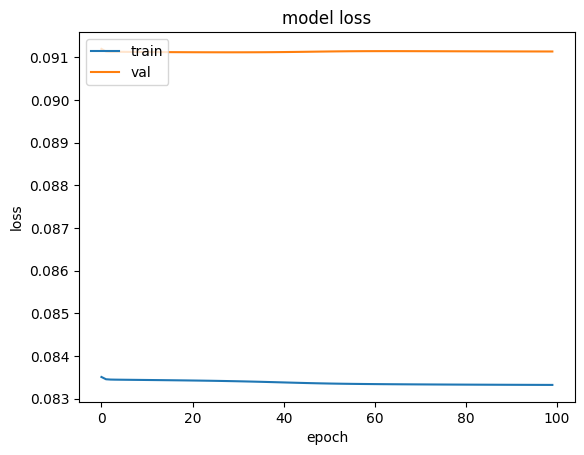

In [ ]:
plt.plot(historico_lstm.history['loss'])
plt.plot(historico_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_lstm = load_model("./lstm")
model_lstm.evaluate(test_data, y_test, batch_size=1)

1502/1502 [==============================] - 3s 2ms/step - loss: 0.3162


0.31624099612236023

1502/1502 [==============================] - 3s 2ms/step


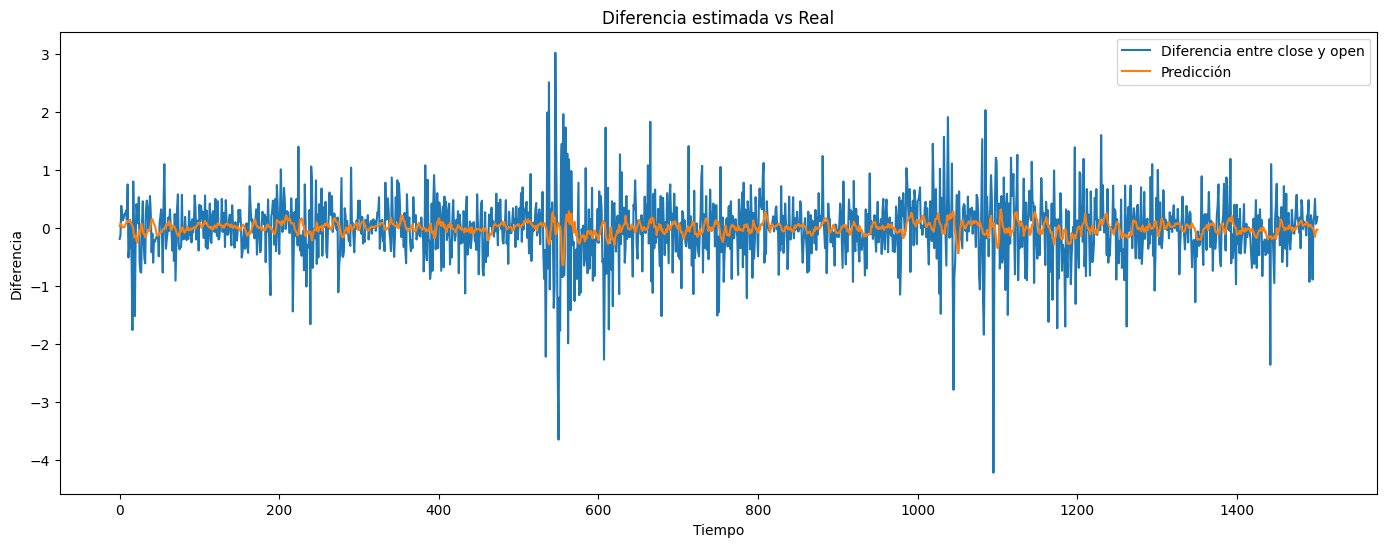

In [ ]:
pred = model_lstm.predict(test_data, batch_size=1)

plt.figure(figsize=(17, 6))

plt.plot(np.arange(len(y_test)), y_test, label='Diferencia entre close y open')
plt.plot(np.arange(len(pred)), pred, label='Predicción')
plt.xlabel('Tiempo')
plt.ylabel('Diferencia')
plt.title('Diferencia estimada vs Real')
plt.legend(loc='best')

plt.show()

In [ ]:
test_prediction(pred, test_df)

<ipython-input-115-51b1f51c6fe1>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.S = int(long_signal * 100)


2018-01-02 00:00:00 send buy order for 3 shares price=45.90999984741211
2018-01-02 00:00:00 total=9998, cash=9998
2018-01-03 00:00:00 send buy order for 7 shares price=45.4900016784668
2018-01-03 00:00:00 total=9998, cash=9998
2018-01-04 00:00:00 send buy order for 7 shares price=45.560001373291016
2018-01-04 00:00:00 total=10002, cash=10002
2018-01-05 00:00:00 send buy order for 0 shares price=46.02000045776367
2018-01-05 00:00:00 total=10002, cash=10002
2018-01-08 00:00:00 send buy order for 0 shares price=45.95000076293945
2018-01-08 00:00:00 total=10002, cash=10002
2018-01-09 00:00:00 send buy order for 1 shares price=46.0
2018-01-09 00:00:00 total=10002, cash=10002
2018-01-10 00:00:00 send buy order for 1 shares price=46.22999954223633
2018-01-10 00:00:00 total=10002, cash=10002
2018-01-11 00:00:00 send buy order for 4 shares price=46.22999954223633
2018-01-11 00:00:00 total=10001, cash=10001
2018-01-12 00:00:00 send buy order for 8 shares price=46.279998779296875
2018-01-12 00:00

En comparación con los resultados obtenidos para CocaCola con los indicadores anteriores, donde el mejor PnL obtenido en test fue de 7,6%, el rendimiento obtenido con esta estrategia es de casi el doble (12,4%). Además, se podría modificar el umbral para tener en cuenta la aversión al riesgo, lo que afectaría a los beneficios.

Inicialmente, la estrategia seguida consiste en comprar S acciones al precio de apertura si la señal es mayor que un umbral, mientras que si la señal es menor, no se actúa. Otra posible estrategia sería, dado que hemos entrenado un regresor, que el número de acciones a comprar cuando predecimos que el open estará por debajo del close sea proporcional a a esa diferencia, es decir, si la diferencia es de 0.1 se compran 10 acciones pero si se predice que sea de 0.4 se comprarán 40 acciones. Es un mayor riesgo pero también puede suponer mayores beneficios. Implementando esta estrategia, en la que se multiplica la diferencia por 100 (ya que los valores rondan todo el rato valores menores que 1) se consigue mejorar el resultado subiendo a un PnL en test de 15,957%.

## Predicciones NVIDIA

In [ ]:
# Obtenemos los datos de train y test, y obtenemos los targets. En nuestro caso, se realizará una predicción de la diferencia entre close y open.
ticker = 'NVDA'

train_df = load_data(ticker, '2001-1-1', '2017-12-31')
test_df = load_data(ticker, '2018-1-1', '2023-12-31')

y_train = train_df['Close'] - train_df['Open']
y_test = test_df['Close'] - test_df['Open']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_df['close-open'] = train_df['Close'] - train_df['Open']
train_df['close-open/open'] = (train_df['Close'] - train_df['Open'])/train_df['Open']
train_df['high-low'] = train_df['High'] - train_df['Low']
train_df['high-low/low'] = (train_df['High'] - train_df['Low'])/train_df['Low']
train_df['high-open/open'] = (train_df['High'] - train_df['Open'])/train_df['Open']
train_df['open-low/open'] = (train_df['Open'] - train_df['Low'])/train_df['Open']
train_df['close-low/close'] = (train_df['Close'] - train_df['Low'])/train_df['Close']
train_df['high-close/close'] = (train_df['High'] - train_df['Close'])/train_df['Close']

test_df['close-open'] = test_df['Close'] - test_df['Open']
test_df['close-open/open'] = (test_df['Close'] - test_df['Open'])/test_df['Open']
test_df['high-low'] = test_df['High'] - test_df['Low']
test_df['high-low/low'] = (test_df['High'] - test_df['Low'])/test_df['Low']
test_df['high-open/open'] = (test_df['High'] - test_df['Open'])/test_df['Open']
test_df['open-low/open'] = (test_df['Open'] - test_df['Low'])/test_df['Open']
test_df['close-low/close'] = (test_df['Close'] - test_df['Low'])/test_df['Close']
test_df['high-close/close'] = (test_df['High'] - test_df['Close'])/test_df['Close']

In [ ]:
y_train = y_train.shift(-1).dropna().to_numpy()
y_test = y_test.shift(-1).dropna().to_numpy()

In [ ]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
train_df.describe()

,Open,High,Low,Close,Adj Close,Volume,close-open,close-open/open,high-low,high-low/low,high-open/open,open-low/open,close-low/close,high-close/close
count,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4.276000e+03,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000
mean,6.205703,6.306334,6.096997,6.206029,5.930943,6.859752e+07,0.000326,0.000344,0.209337,0.041774,0.020436,0.020168,0.020067,0.020507
std,8.710507,8.812078,8.577457,8.706401,8.644513,4.798331e+07,0.229314,0.030141,0.300245,0.028299,0.023371,0.020087,0.019857,0.021429
min,0.608333,0.656667,0.600000,0.614167,0.563377,4.564400e+06,-3.785000,-0.179241,0.019167,0.006698,0.000000,0.000000,0.000000,0.000000
25%,2.582500,2.651875,2.522188,2.592500,2.378105,3.873210e+07,-0.054687,-0.014885,0.077969,0.023395,0.006068,0.006349,0.007044,0.006193
50%,3.697500,3.757500,3.632500,3.697500,3.407714,5.768580e+07,0.000000,0.000000,0.127500,0.034034,0.013603,0.014386,0.014313,0.013795
75%,5.313542,5.418750,5.215625,5.312708,4.976429,8.410755e+07,0.055000,0.014343,0.210000,0.050878,0.026857,0.026905,0.026195,0.027580
max,54.327499,54.667500,53.650002,54.240002,53.666416,9.230856e+08,2.182499,0.349138,6.437500,0.396018,0.359914,0.192696,0.277955,0.274194


In [ ]:
sequence_len = 7

train_data = train_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'close-open', 'high-low']).to_numpy(dtype="float")[:-1, :]
test_data = test_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']).to_numpy(dtype="float")[:-1, :]

# Crear las secuencias de datos para la LSTM
train_data = create_sequence(sequence_len, train_data, 1)
test_data = create_sequence(sequence_len, test_data, 1)
y_train = y_train[(sequence_len - 1):]
y_test = y_test[(sequence_len - 1):]

# Quedarse con el último 20% para validación, el resto para entrenar
valid_data = train_data[int(0.8*len(train_data)):]
train_data = train_data[:int(0.8*len(train_data))]

y_valid = y_train[int(0.8*len(y_train)):]
y_train = y_train[:int(0.8*len(y_train))]

In [ ]:
num_cells = 100
lr = 0.0001
epochs = 100

model_lstm = Sequential()
model_lstm.add(LSTM(num_cells, input_shape=(train_data.shape[1], train_data.shape[2])))
model_lstm.add(Dense(1))

checkpoint = ModelCheckpoint('./lstm', monitor='val_loss', verbose=1, save_best_only=True)
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error')
historico_lstm = model_lstm.fit(train_data, y_train, epochs=epochs, callbacks=[checkpoint], validation_data=(valid_data, y_valid), batch_size=128, verbose=1, shuffle=False, validation_freq = 1)

Epoch 1/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0124
Epoch 1: val_loss improved from inf to 0.21549, saving model to ./lstm
27/27 [==============================] - 6s 129ms/step - loss: 0.0119 - val_loss: 0.2155
Epoch 2/100
22/27 [=======================>......] - ETA: 0s - loss: 0.0137
Epoch 2: val_loss improved from 0.21549 to 0.21548, saving model to ./lstm
27/27 [==============================] - 3s 105ms/step - loss: 0.0118 - val_loss: 0.2155
Epoch 3/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0121
Epoch 3: val_loss improved from 0.21548 to 0.21548, saving model to ./lstm
27/27 [==============================] - 4s 141ms/step - loss: 0.0118 - val_loss: 0.2155
Epoch 4/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0124
Epoch 4: val_loss improved from 0.21548 to 0.21547, saving model to ./lstm
27/27 [==============================] - 3s 124ms/step - loss: 0.0118 - val_loss: 0.2155
Epoch 5/100
26/27 [=========================

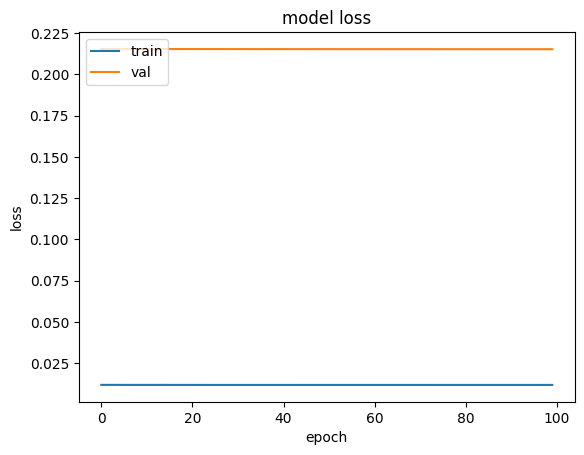

In [ ]:
plt.plot(historico_lstm.history['loss'])
plt.plot(historico_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_lstm = load_model("./lstm")
model_lstm.evaluate(test_data, y_test, batch_size=1)

1502/1502 [==============================] - 3s 2ms/step - loss: 24.7312


24.731246948242188

1502/1502 [==============================] - 3s 2ms/step


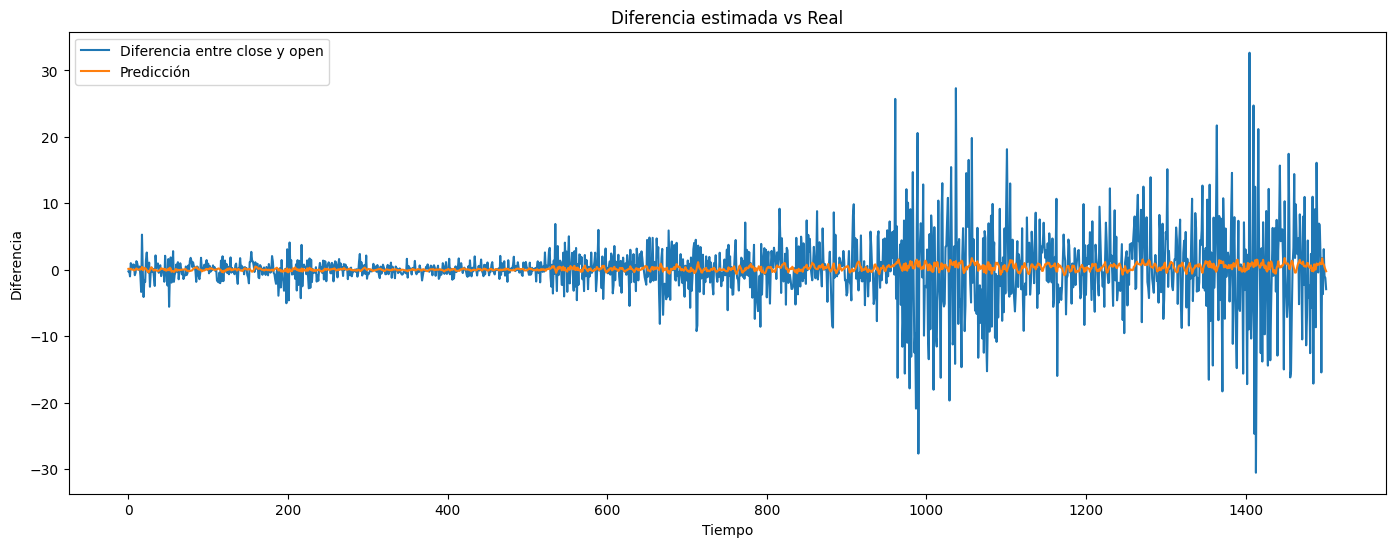

In [ ]:
pred = model_lstm.predict(test_data, batch_size=1)

plt.figure(figsize=(17, 6))

plt.plot(np.arange(len(y_test)), y_test, label='Diferencia entre close y open')
plt.plot(np.arange(len(pred)), pred, label='Predicción')
plt.xlabel('Tiempo')
plt.ylabel('Diferencia')
plt.title('Diferencia estimada vs Real')
plt.legend(loc='best')

plt.show()

In [ ]:
test_prediction(pred, test_df)

<ipython-input-115-51b1f51c6fe1>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.S = int(long_signal * 100)


2018-01-02 00:00:00 send buy order for 14 shares price=48.94499969482422
2018-01-02 00:00:00 total=10012, cash=10012
2018-01-03 00:00:00 send buy order for 16 shares price=51.025001525878906
2018-01-03 00:00:00 total=10045, cash=10045
2018-01-04 00:00:00 send buy order for 5 shares price=53.939998626708984
2018-01-04 00:00:00 total=10043, cash=10043
2018-01-05 00:00:00 send buy order for 17 shares price=53.54750061035156
2018-01-05 00:00:00 total=10048, cash=10048
2018-01-08 00:00:00 send buy order for 4 shares price=55.099998474121094
2018-01-08 00:00:00 total=10050, cash=10050
2018-01-09 00:00:00 send buy order for 3 shares price=55.55500030517578
2018-01-09 00:00:00 total=10049, cash=10049
2018-01-10 00:00:00 send buy order for 2 shares price=54.54999923706055
2018-01-10 00:00:00 total=10052, cash=10052
2018-01-11 00:00:00 total=10052, cash=10052
2018-01-12 00:00:00 total=10052, cash=10052
2018-01-16 00:00:00 send buy order for 10 shares price=56.01250076293945
2018-01-16 00:00:00 t

Al igual que en el caso de Coca-Cola, con NVIDIA y siguiendo nuestra estrategia proporcional a la diferencia predicha entre el valor de close y open, conseguimos mejorar cualquiera de los resultados de los apartados 2 y 3 donde el mejor PnL era de 435%. En nuestro caso, somos capaces de mejorar dicho valor hasta el 638%.

Cabe destacar por las trazas obtenidas del Backtester, que hay algunos casos en los que no se tiene suficiente dinero para comprar el número de acciones determinado por la diferencia al precio que se venden. En esos casos simplemente no se compran las acciones. Se podrían pedir prestamos del resto de las acciones o ponerse en corto pero hemos preferido no hacerlo.